In [ ]:
!pip install pip install bayesian-optimization

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV 
from sklearn.linear_model import Perceptron, LogisticRegressionCV, RidgeClassifierCV, SGDClassifier, PassiveAggressiveClassifier, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,mean_absolute_error, confusion_matrix, silhouette_score
from sklearn.metrics import roc_auc_score,roc_curve, auc, classification_report,precision_score,recall_score,log_loss,f1_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, LabelEncoder, OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer,minmax_scale,PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import RBFSampler
from sklearn import tree
# import pandas_bokeh
from sklearn.decomposition import PCA,KernelPCA
from sklearn.calibration import CalibratedClassifierCV
from numpy import mean, std
import pandas.testing as tm
from scipy import stats
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import ExtraTreeClassifier
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

# from yellowbrick.features import PCA as PCA_YB
# from yellowbrick.features.radviz import RadViz
# from yellowbrick.features import pca_decomposition
# from yellowbrick.features import Manifold
# from yellowbrick.features import JointPlotVisualizer
# from yellowbrick.classifier import ClassificationReport
# from yellowbrick.classifier import PrecisionRecallCurve
# from yellowbrick.classifier import ClassPredictionError
# from yellowbrick.model_selection import LearningCurve
# from yellowbrick.model_selection import CVScores
# from yellowbrick.model_selection import FeatureImportances
# from yellowbrick.features import ParallelCoordinates
# from yellowbrick.model_selection import RFECV
# from yellowbrick.classifier import ROCAUC


#other
from math import sqrt
import inspect
from matplotlib.font_manager import FontProperties
from scipy.stats import loguniform, uniform
from bokeh import io
import datetime
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# import eli5
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Part B**
### **Data Transformation**
We have chosen a few data transformation techniques to be part of the hyperparameter tuning procedure. For example, the Birth year of the customer can be further transformed into age, giving us a new perspective on the dataset. Each data transformation technique is to be looped to give different combinations so that we can deduct which data transformation technique works the best for the given dataset.

The column processing method can be detailed as followed. The enrolment date will be processed into either days only or day, month and year value. Then, the null value of the income will be treated by using KNN imputation, forward fill, backward fill, mean, median or directly drop the column. Next, if the income column still stays in the data, it will either not be processed, binned, normalized, or binned and normalized.

In order to speed up the training process and produce a better classifier, we decided to pick only 8 essential features for each classifier based on the results obtained from Part A - Feature Importance Ranking chart. Each data is also looped with different scalers so that we can see which scaler suits the most to a given combination.

Due to the imbalance label inside the dataset, we decided to resample the training dataset with a different sampling method instead of stratifying the data. With this method, we are able to ensure that the model has no imbalanced classifiers and all the individuals within the dataset are represented properly.


In [ ]:
# import pandas as pd
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

# from sklearn.preprocessing import OrdinalEncoder
# import numba
# import numpy as np
# from scipy import stats


DATASET_URL = "https://gist.githubusercontent.com/YHYeoh/ad1a7f7170c72d621d05a70637540152/raw/5a6059c199e2c46d2f3d258f03d93cfea98e2749/marketing_campaign.csv"
data = pd.read_csv(DATASET_URL, sep = ';')

education_order = [['Basic', 'Graduation', 'Master', '2n Cycle', 'PhD']]
ordinal_encoder = OrdinalEncoder(categories=education_order)

data["Education"] = (ordinal_encoder.fit_transform(data["Education"].values.reshape(-1, 1))).astype(int)
# print(ordinal_encoder.categories_)

#encode categorical column
categorical = ['Marital_Status']
marital_status_ohe = pd.get_dummies(data.Marital_Status,prefix="Marital")
data = data.join(marital_status_ohe)

#drop original column after encoding
data.drop(['Marital_Status'], axis = 1,inplace = True)

tunable_cols = ["Year_Birth", "Income","Dt_Customer"]

def getKeyVal(inDict):
  for i in inDict:
    key=i
    val= inDict[i]
  return key,val

def getIterativeImputedIncome(data):
  imr = IterativeImputer(random_state=42, max_iter=100, min_value= data['Income'].min())
  imr = imr.fit(data[['Income']])
  data['Income'] = imr.transform(data[['Income']]).ravel()
  return data

def getKNNImputedIncome(data):
	imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
	data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
	return data

def getAgeFromDateBirth(data):
	year = datetime.datetime.now().year
	data['Year_Birth'] = data['Year_Birth'].apply(lambda x : year - x )
	return data

def extractFromDate(data):
	data['enroll_year'] = pd.DatetimeIndex(data.Dt_Customer).year
	data['enroll_month'] = pd.DatetimeIndex(data.Dt_Customer).month
	data['enroll_day'] = pd.DatetimeIndex(data.Dt_Customer).day
	data.drop(['Dt_Customer'], axis = 1, inplace= True)
	return data

def convertToDays(data):
	vfunc = np.vectorize(lambda x: (datetime.datetime.now() - x).days)
	data['Dt_Customer'] = vfunc(pd.DatetimeIndex(data.Dt_Customer).to_pydatetime())
	return data

def getBinnedIncome(data):
	data['Income'] = pd.cut(data['Income'], bins=[0, 15000, 60000, 110000, 700000], labels=False, precision=0).convert_dtypes()
	return data

def getNormalizedIncome(data):
	data = data[(np.abs(stats.zscore(data[['Income']])) < 3)]
	return data

def getNormalizedAndBinnedIncome(data):
	data = data[(np.abs(stats.zscore(data[['Income']])) < 3)]
	data['Income'] = pd.cut(data['Income'], bins=[0, 15000, 60000, 110000, 700000], labels=False, precision=0).convert_dtypes()
	return data

def getOverSampler():
    oversampler = RandomOverSampler(sampling_strategy=0.5,random_state=42)
    # x,y = oversampler.fit_resample(x, y)
    return oversampler


def getUnderSampler():
    undersampler = RandomUnderSampler(sampling_strategy='majority',random_state=42)
    # x,y = undersampler.fit_resample(x, y)
    return undersampler

def getHypeYearBirth(data):
	hyper_year_birth = [
    {'Not age engineering':data},
		{'Age':getAgeFromDateBirth(data.copy())}
	]
	return hyper_year_birth

hyper_dt_customer = [
	{'extractFromDate':extractFromDate(data.copy())},
	{'convertToDays':convertToDays(data.copy())}
]

def getPreprocessingIncome(data):
	preprocessing_income = [
    {'getIterativeImputedIncome':getIterativeImputedIncome(data.copy())},
		{'getKNNImputedIncome':getKNNImputedIncome(data.copy())},
		{'fillNa method = ffill':data.copy().fillna(method = "ffill")}, #ffill
		{'fillNa method = bfill':data.copy().fillna(method = "bfill")}, #bfill
		{'mean imputed':data.copy().fillna(data.mean())}, #mean imputed
		{'median imputed':data.copy().fillna(data.median())}, #median imputed
		{'Income dropped':data.copy().dropna(subset=['Income'])}
	]
	return preprocessing_income

def getHypeIncome(data):
	hyper_income = [
  {'No income engineering':data},
	{'Binned Income':getBinnedIncome(data.copy())},
	{'Normalized Income':getNormalizedIncome(data.copy())},
	{'Binned and Normalized Income':getNormalizedAndBinnedIncome(data.copy())}
	]
	return hyper_income


def getDataSampling():
	hyper_oversampling = [
  {'No data sampling': None},
	{'Under sampling':getUnderSampler()},
	{'Over sampling':getOverSampler()},
	]
	return hyper_oversampling


# hyperparams = {
# 	"Year_Birth":[ data['Year_Birth'], getAgeFromDateBirth(data.copy())],	
# 	"Income": [data['Income'], getBinnedIncome(data['Income']), getNormalizedIncome()]
# }

In [ ]:
def hasmethod(obj, name):
	return inspect.ismethod(getattr(obj, name, None))

def setupPreprocessPipeline(scaler,numerical_no_bool):
	ss = Pipeline(steps=[('scaler',scaler)])
	#ohe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown = 'ignore'))])
	preprocess = ColumnTransformer(
                    transformers=[
                        ('cont', ss, numerical_no_bool)
                        #('cat', ohe, categorical),
                        #('le', le, ordinal),
                        ],remainder='passthrough')
	return preprocess

   
def overallClassificationReport(model,classes):
	visualizer = ClassificationReport(model, classes=classes, support=True) #might can change
	visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
	if(model.__class__.__name__ == "XGBClassifier"): #special treatment for xgboost as it reordered column
		model.fit(X_train, y_train)
		reorderedColumn = model.get_booster().feature_names
		reordered_Xtest = X_test[reorderedColumn] #reorderColumn
		visualizer.score(X_test, y_test)        
		visualizer.show()
		return
	visualizer.score(X_test, y_test)        # Evaluate the model on the test data
	visualizer.show()


def overall_feature_importance(model,X_train,y_train):
	labels = list(map(lambda s: s.title(), X.columns))
	viz = FeatureImportances(model, labels=labels,encoder={1: 'yes',0: 'no'}, relative=False, topn = 8)
	viz.fit(X, y)
	viz.show()

def has_feature_imp(classifier):
	status = False
	if (hasattr(classifier,'coef_')):
		status = True
	elif (hasattr(classifier,'coefs_')):
		status = True
	elif (hasattr(classifier,'feature_importances_')):
		status = True
	print("Cannot extract feature importance, skipping")
	return status


### **Evaluate the performance of shortlisted classifiers**
As for the result, we find out that some of the modeling techniques do not perform very well with our dataset. It turns out that some modeling techniques might require more features to be accurate. Therefore, we decided to just nitpick some modeling techniques that produce acceptable results and perform Grid Search CV for their respective parameters for optimization purposes.

The dataset will be evaluated through these few criterias and the final results will be exported into an excel file for further analysis, the program will also display the top 5 best performing models for each metrics score as results in the terminal. Criterias involved are, how the income, date-time and year columns in the dataset are processed, the sampling method utilized for  each iterations and also the final results are categorized into classifier and scaler just like before in part A. We will evaluate the efficiency of these classifier-to-scaler pairs through a final train-test metrics score results, which will be produced after running it through Stratified  K-Fold and retrieving the average results. The total results will be stored into an excel file, similarly to part A’s metric score evaluation phase. 

To further improve the performance speed of our models, we introduced the nystrom method to process and perform subsampling on our data within the kernel. This is achieved by implementing the nystrom library into our modelling process. We will also be introducing the nystroem method again when running our RandomizedSearchCV. Before the randomized search, the data will go through the similar process status mentioned above including null value  forward fill,  date column transformation,  income column transformation, training data oversampling, data scaling using Quantile Transformer, Nystroem data transformation and lastly model parameter search.  The search included the models of SVC, LGBM Classifier, Random Forest Classifier, XGB Classifier and Logistic Regression. The result of the search was shown as below: 


In [ ]:
model_results=[]
def cross_validate(classifier, cv,X_train,y_train,dtColumnStatus
                   ,incomePreproStatus,IncomeEngiStatus,yearProcessStatus,dataSamplingStatus,numerical_no_bool,dataSamplingMethod):
  scalers = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(), RobustScaler(),QuantileTransformer()]
  train_acc = []
  test_acc = []
  mean = []
  model_result= []
  for scaler in scalers:
    preprocess = setupPreprocessPipeline(scaler,numerical_no_bool)
    pipeline = Pipeline(steps=[
	        ('preprocess', preprocess),
	        ('classifier', classifier)
    ])

    train_acc = []
    test_acc = []
    train_recall = []
    test_recall = []
    train_precision = []
    test_precision = []
    train_f1 = []
    test_f1 = []
    train_auc_roc = []
    test_auc_roc = []
    mean = []

    for train_ind, val_ind in cv.split(X_train, y_train):
      X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
      pipeline.fit(X_t, y_t)
      y_hat_t = pipeline.predict(X_t)
      train_acc.append(accuracy_score(y_t, y_hat_t))
      train_recall.append(recall_score(y_t, y_hat_t))
      train_precision.append(precision_score(y_t, y_hat_t))
      train_f1.append(f1_score(y_t, y_hat_t))
      train_auc_roc.append(roc_auc_score(y_t, y_hat_t))
      X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
      
      if(dataSamplingMethod != None):
        correctOrdering = X_val.columns
        X_val, y_val = dataSamplingMethod.fit_resample(X_val, y_val)
        X_val = pd.DataFrame(X_val)
        y_val = pd.DataFrame(y_val)
        X_val.columns = correctOrdering
      
      y_hat_val = pipeline.predict(X_val)
      test_acc.append(accuracy_score(y_val, y_hat_val))
      test_recall.append(recall_score(y_val, y_hat_val))
      test_precision.append(precision_score(y_val, y_hat_val))
      test_f1.append(f1_score(y_val, y_hat_val))
      test_auc_roc.append(roc_auc_score(y_val, y_hat_val))
    
    model_results.append({
            'classifier':classifier.__class__.__name__,
            'scalerName':scaler.__class__.__name__,
            'dataSampling':dataSamplingStatus,
            'dtColumn':dtColumnStatus,
            'incomePreprocessing':incomePreproStatus,
            'IncomeEngineering':IncomeEngiStatus,
            'yearProcess':yearProcessStatus,
            'train_accuracy':np.mean(train_acc),
            'test_accuracy':np.mean(test_acc),
            'train_recall':np.mean(train_recall),
            'test_recall':np.mean(test_recall),
            'train_precision':np.mean(train_precision),
            'test_precision':np.mean(test_precision),
            'train_f1':np.mean(train_f1),
            'test_f1':np.mean(test_f1),
            'train_auc_roc':np.mean(train_auc_roc),
            'test_auc_roc':np.mean(test_auc_roc)
        })

In [ ]:
import warnings
warnings.filterwarnings("default")

In [ ]:
#logistic, svm, LGBMClassifier, 
models = [
	XGBClassifier(),
  RandomForestClassifier(),
  LGBMClassifier(),
	SVC(kernel = 'linear',max_iter= -1), 
	LogisticRegression(), 
	]
tunable_cols = ["Year_Birth", "Income","Dt_Customer"]
model_result= []
classes = ["no", "yes"]

In [ ]:
y_data = data.Response # print(y.value_counts())
x_data = data.drop(['Response'], axis=1)
print(x_data.columns)

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Marital_Absurd',
       'Marital_Alone', 'Marital_Divorced', 'Marital_Married',
       'Marital_Single', 'Marital_Together', 'Marital_Widow', 'Marital_YOLO'],
      dtype='object')


In [ ]:
#defines column to drop for each classifier
classifier_columns = {
		"SVC":["AcceptedCmp2","AcceptedCmp5","MntSweetProducts","Complain","MntWines","Year_Birth","MntGoldProds","NumDealsPurchases"],
		"LGBMClassifier":["Kidhome","MntWines","Education","Teenhome","AcceptedCmp4","MntFishProducts","AcceptedCmp2","AcceptedCmp5"],
		"RandomForestClassifier":["Kidhome","Teenhome","Education","MntWines","MntFishProducts","AcceptedCmp4","AcceptedCmp5","AcceptedCmp2"],
		"XGBClassifier":["AcceptedCmp2","AcceptedCmp5","Complain","Marital_Together","Marital_Married","NumDealsPurchases","Kidhome","Year_Birth"],
		"LogisticRegression":["AcceptedCmp2","AcceptedCmp5","Complain","AcceptedCmp1","enroll_year","Marital_Married","Marital_Together","Year_Birth"]
}

### **Automated Hyperparameter Tuning via Data Transformation**

Once again before the randomized search CV is ran, the data will go through the similar process status mentioned above including null value  forward fill,  date column transformation,  income column transformation, training data oversampling, data scaling using Quantile Transformer, Nystroem data transformation and lastly model parameter search.  The search included the models of SVC, LGBM Classifier, Random Forest Classifier, XGB Classifier and Logistic Regression. The results of the search were recorded in a DataFrame. Then, the DataFrame will be applied into a Voting Function to create a model and 


The results of the automated hyperparameter tuning has shown that the top 3 models to return the highest accuracy are the Logistic Regression, SVC and Random Forest Classifier. We will focus on the Logistic Regression to obtain our optimal data transformation methods. The results show that our Income data must be Normalized and the pre-processing method chosen for the Income data is to fill the null values by bfill method. No data sampling is required and the date time required will be extracted from the original dataset’s date column. The scaler utilized is the MinMaxScaler and we will process the Year_Birth column from the original dataset and transform it into age as it will represent the  data more accurately. Hence this is how our parameters will be tuned for later when generating the final model.

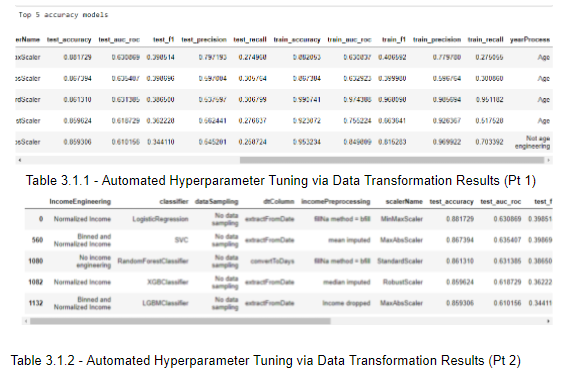

In [ ]:
import warnings
from sklearn.kernel_approximation import Nystroem
model_results=[]
warnings.filterwarnings("ignore")
problemSet=None;
counter=0;
nystroem = Nystroem()
for processed_dt_cust in hyper_dt_customer:
  dtColumnMethod,data= getKeyVal(processed_dt_cust)
  for preprocessed_income in getPreprocessingIncome(data):
    incomePreprocessMethod,data= getKeyVal(preprocessed_income)
    for processed_income_col in getHypeIncome(data):
      incomeEngineeringMethod,data= getKeyVal(processed_income_col)
      for processed_year_birth in getHypeYearBirth(data):
        processYearMethod,data = getKeyVal(processed_year_birth) # print(data)
        numerical_bool_col = [x for x in data.columns if data[x].isin([0,1]).all()] # print(numerical_bool_col)
        numerical_scalable_col = [x for x in data.columns if x not in numerical_bool_col]
        y_data = data.Response # print(y.value_counts())
        x_data = data.drop(['Response'], axis=1)
        #should auto drop columns based on pearson correlation , feature importance
        #X.drop(['NumStorePurchases','NumCatalogPurchases','MntFruits','MntFishProducts','MntSweetProducts','MntWines'], axis = 1, inplace = True)
        

        
        for model in models:
            x_dropped_data = x_data.drop([x for x in x_data.columns if x not in classifier_columns[model.__class__.__name__]],axis = 1)
            nummerical_no_bool = [x for x in numerical_scalable_col if x in x_dropped_data.columns]
            X_train, X_test, y_train, y_test = train_test_split(x_dropped_data,y_data, test_size=0.25, random_state=42)
            for dataSamplingInfo in getDataSampling():
              dataSamplingDesc,dataSamplingMethod= getKeyVal(dataSamplingInfo)
#             print(X_train.isnull().values.any(),y_train.isnull().values.any(),"\n")
              if(X_train.isnull().values.any()==True):
                  problemSet = X_train
                  print(X_train.isnull())
                  break
              counter+=1
              # print("Dt                : ",dtColumnMethod,"\n")
              # print("Preprocess Income : ",incomePreprocessMethod,"\n")
              # print("Income Engineering: ",incomeEngineeringMethod,"\n")
              # print("Process Year      : ",processYearMethod,"\n") # print(numerical_scalable_col) # print(data.info())
              # print("Data Sampling     : ",dataSamplingDesc,"\n")
              
              if(counter%100==0):
                  print("Counter : ",counter)
              X_train_transformed = nystroem.fit_transform(X_train)
              X_test_transformed = nystroem.transform(X_test)

              cross_validate(model,KFold(n_splits=10),X_train,y_train,dtColumnMethod,incomePreprocessMethod
                                                    ,incomeEngineeringMethod,processYearMethod,dataSamplingDesc,nummerical_no_bool,dataSamplingMethod)

In [ ]:
resultDF = pd.DataFrame.from_records(model_results,columns=['IncomeEngineering','classifier','dataSampling','dtColumn','incomePreprocessing'
                                                           ,'scalerName','test_accuracy'
                                                           ,'test_auc_roc','test_f1','test_precision','test_recall'
                                                           ,'train_accuracy','train_auc_roc','train_f1','train_precision',
                                                          'train_recall','yearProcess'])
# resultDF=resultDF.dropna(how='all')

# roc_auc
# f1

In [ ]:
def saveXls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            switcher  = {
                0: 'By Classifier Name',
                1: 'By Accuracy',
                2: 'By Precision',
                3: 'By Recall',
                4: 'By F1-Score',
                5: 'By ROC-AUC Score'
            }
            df.to_excel(writer,switcher.get(n,''))
        writer.save()

In [ ]:
from pandas import ExcelWriter
dfList = []

accColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_accuracy','test_accuracy']
precColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_precision','test_precision']
recallColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_recall','test_recall']
f1Column=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_f1','test_f1']
roc_aucColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_auc_roc','test_auc_roc']

dfList.append(resultDF.sort_values(by=['classifier','scalerName'],ascending=False, ignore_index=True))
dfList.append(resultDF[accColumn].sort_values(by=['test_accuracy'],ascending=False, ignore_index=True))
dfList.append(resultDF[precColumn].sort_values(by=['test_precision'],ascending=False, ignore_index=True))
dfList.append(resultDF[recallColumn].sort_values(by=['test_recall'],ascending=False, ignore_index=True))
dfList.append(resultDF[f1Column].sort_values(by=['test_f1'],ascending=False, ignore_index=True))
dfList.append(resultDF[roc_aucColumn].sort_values(by=['test_auc_roc'],ascending=False, ignore_index=True))

print('Top 5 accuracy models')
display(resultDF.sort_values(by=['test_accuracy'],ascending=False, ignore_index=True).drop_duplicates('classifier',keep='first').head(5))
print('Top 5 precise models')
display(resultDF.sort_values(by=['test_precision'],ascending=False, ignore_index=True).drop_duplicates('classifier',keep='first').head(5))
print('Top 5 recall models')
display(resultDF.sort_values(by=['test_recall'],ascending=False, ignore_index=True).drop_duplicates('classifier',keep='first').head(5))
print('Top 5 most roc-auc-score models')
display(resultDF.sort_values(by=['test_auc_roc'],ascending=False, ignore_index=True).drop_duplicates('classifier',keep='first').head(5))

saveXls(dfList, r'.\Automated-Hyperparameter-Tuning.xlsx')

,IncomeEngineering,classifier,dataSampling,dtColumn,incomePreprocessing,scalerName,test_accuracy,test_auc_roc,test_f1,test_precision,test_recall,train_accuracy,train_auc_roc,train_f1,train_precision,train_recall,yearProcess
0,No income engineering,XGBClassifier,No data sampling,extractFromDate,getIterativeImputedIncome,StandardScaler,0.866071,0.592798,0.303659,0.634524,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
1,No income engineering,XGBClassifier,No data sampling,extractFromDate,getIterativeImputedIncome,MinMaxScaler,0.866071,0.592798,0.303659,0.634524,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
2,No income engineering,XGBClassifier,No data sampling,extractFromDate,getIterativeImputedIncome,MaxAbsScaler,0.866071,0.592798,0.303659,0.634524,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
3,No income engineering,XGBClassifier,No data sampling,extractFromDate,getIterativeImputedIncome,RobustScaler,0.866071,0.592798,0.303659,0.634524,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
4,No income engineering,XGBClassifier,No data sampling,extractFromDate,getIterativeImputedIncome,QuantileTransformer,0.866071,0.592798,0.303659,0.634524,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
5,No income engineering,XGBClassifier,Under sampling,extractFromDate,getIterativeImputedIncome,StandardScaler,0.590343,0.590343,0.325974,0.900476,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
6,No income engineering,XGBClassifier,Under sampling,extractFromDate,getIterativeImputedIncome,MinMaxScaler,0.590343,0.590343,0.325974,0.900476,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
7,No income engineering,XGBClassifier,Under sampling,extractFromDate,getIterativeImputedIncome,MaxAbsScaler,0.590343,0.590343,0.325974,0.900476,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
8,No income engineering,XGBClassifier,Under sampling,extractFromDate,getIterativeImputedIncome,RobustScaler,0.590343,0.590343,0.325974,0.900476,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering
9,No income engineering,XGBClassifier,Under sampling,extractFromDate,getIterativeImputedIncome,QuantileTransformer,0.590343,0.590343,0.325974,0.900476,0.205940,0.882738,0.628796,0.403229,0.810566,0.268457,Not age engineering


### **Grid Search for Parameter Tuning**
After selecting out the best models and best parameters for our final models through our hyperparameter tuning, we will also be running the same classifiers and scalers through a RandomSearch CV once again. This time we will narrow down the processing of the data based on the results received from our previous function and transform the data based on that. The transformed data will then be fitted into nystroem and then passed into the Random Search Cross Validation function. The final results will be passed back for us to review via dataframes and excel files and through those results, we will pick our final 3 models used for ensembling.



To evaluate our model as mentioned above, we have chosen accuracy as our main evaluation metric as it's the most common and the easiest to understand. A high accuracy score meant that the model is accurate in predicting both instances as a whole, hence it will allow the hypermarket to have more confidence in the results of our model. The use of stratified and unstratified data in testing and training our model can also be said to have contributed enormously in helping us determine the true accuracy of our models.

The accuracy above showed that SVC performed the best in terms of test score, 84% accuracy even though it has the worst of training scores at the accuracy of 75%. In contrast, LGBM Classifiers perform the best among the three in terms of training score at accuracy of 92% but the worst when it comes to testing coming in at 81%. In the meantime, Logistic Regression was slightly underperformed when compared against SVC in terms of test score at 83% for accuracy but 77% when it comes to accuracy during training score. This shows that SVC was good in terms of generalization and it is the most suitable for our data.


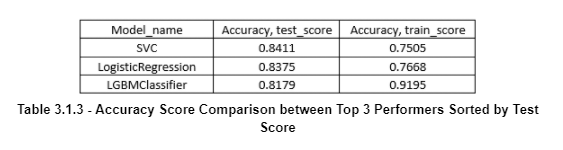

In [ ]:
#svc xgb, rfc, lgbm, logistic
from sklearn.linear_model import LogisticRegression
scoring = 'f1'
fold=10
# featureNumList = list(range(1,X_train.shape[1]))
modelsWithParam = [
         { 
        'model':LogisticRegression(),'param':{'C': np.logspace(-3,3,7),#100,10,1, 0.1, 0.01, 0.001
                                 'fit_intercept':[True,False],
                                 'dual':[True,False],
                                 'penalty':['l2'],
                                 'max_iter':list(range(100,1000,100)),#[50,100,500,1000,2000,4000,8000]
                                 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
        }},
    {
        'model':LGBMClassifier(),'param':{
        'boosting_type':["gbdt","dart","goss","rf"],
        'metric':['binary_logloss'],
        'sub_feature':list(np.arange(0.1,1,10)),
        'num_leaves':list(range(10,50,10)),
        'learning_rate': [1,0.1,0.01,0.005,0.001],
        'n_estimators': list(range(100,1000,100)),
        'min_data':[50],
        'max_depth': list(range(5,20,5)),
        'min_split_gain':list(np.arange(0.1,1,10)),
        'random_state': [42]
    }},
    {
        'model':RandomForestClassifier(),'param':{
            'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    },
    {
        'model':XGBClassifier(),'param':{
            'n_estimators': [400, 700, 1000],
            'colsample_bytree': [0.7, 0.8],
            'max_depth': [15,20,25],
            'reg_alpha': [1.1, 1.2, 1.3],
            'reg_lambda': [1.1, 1.2, 1.3],
            'subsample': [0.7, 0.8, 0.9]
        }
    },
    {
            
        'model':SVC(),'param':{
        'C': [ 1,0.1,10, 100, 1000],  
        'gamma': [0.0001,0.00001], 
        'kernel': ['linear', 'rbf'],
        'random_state': [42] 
    }},
]

In [ ]:
#defines column to drop for each classifier
classifier_columns = {
		"SVC":["AcceptedCmp2","AcceptedCmp5","MntSweetProducts","Complain","MntWines","Year_Birth","MntGoldProds","NumDealsPurchases"],
		"LGBMClassifier":["Kidhome","MntWines","Education","Teenhome","AcceptedCmp4","MntFishProducts","AcceptedCmp2","AcceptedCmp5"],
		"RandomForestClassifier":["Kidhome","Teenhome","Education","MntWines","MntFishProducts","AcceptedCmp4","AcceptedCmp5","AcceptedCmp2"],
		"XGBClassifier":["AcceptedCmp2","AcceptedCmp5","Complain","Marital_Together","Marital_Married","NumDealsPurchases","Kidhome","Year_Birth"],
		"LogisticRegression":["AcceptedCmp2","AcceptedCmp5","Complain","AcceptedCmp1","enroll_year","Marital_Married","Marital_Together","Year_Birth"]
}

In [ ]:
#randomised search cv
from sklearn.kernel_approximation import Nystroem
scoring = "accuracy"
fold=4
y = data.Response # print(y.value_counts())
X = data.drop(['Response'], axis=1)
def modelBestFit(item,X_trains,y_trains,X_tests,y_tests):
    model = item['model']
    paramGrid = item['param']
    search = RandomizedSearchCV(estimator=model, param_distributions= paramGrid
                                ,n_iter=200,n_jobs=-1,pre_dispatch='1*n_jobs'
                                ,scoring = scoring,refit = True,cv=fold
                                ,random_state=42)
    search.fit(X_trains,y_trains)
    test_score =search.score(X_tests,y_tests)
    model_name = model.__class__.__name__
    return {'model_name':model_name,'test_score':test_score,'best_score':search.best_score_,'best_model':search.best_estimator_}

# loop through model based on models and parameter specified
def bestModel(modelsAndParams):
    modelPerformance = pd.DataFrame()
    for item in modelsAndParams:
        
        model = item['model']
        
        x_copy = X.copy()
        x_copy = x_copy.drop([x for x in x_copy.columns if x not in classifier_columns[model.__class__.__name__]],axis = 1)
        
        X_train, X_test, y_train, y_test = train_test_split(x_copy,y, test_size=0.25, random_state=42)
        
        X_train= X_train.fillna(method = "ffill")
        X_test = X_test.fillna(method = "ffill")
        
        if('Dt_Customer' in x_copy.columns):
            X_train = extractFromDate(X_train)
            X_test = extractFromDate(X_test)
        
        if('Income' in x_copy.columns):
            X_train = getNormalizedAndBinnedIncome(X_train)
            X_test = getNormalizedAndBinnedIncome(X_test)
        
        y_train = y_train[y_train.index.isin(X_train.index)]
        y_test = y_test[y_test.index.isin(X_test.index)]
        oversampler = RandomOverSampler(sampling_strategy=0.5,random_state=42)
        X_train,y_train = oversampler.fit_resample(X_train, y_train)
        
        qt = QuantileTransformer(random_state=42)
        X_train = qt.fit_transform(X_train)
        X_test = qt.transform(X_test)
        
        nystroem = Nystroem()
        
        X_train_transformed = nystroem.fit_transform(X_train)
        X_test_transformed = nystroem.transform(X_test)

        result = modelBestFit(item,X_train_transformed,y_train,X_test_transformed,y_test)
        modelPerformance = modelPerformance.append(result,ignore_index=True)
        print(result)
        
    modelPerformance.sort_values(by='test_score',ascending=False,inplace=True)
    return modelPerformance
 
result = bestModel(modelsWithParam)

(2148, 100)
(560, 100)
{'model_name': 'LogisticRegression', 'test_score': 0.8410714285714286, 'best_score': 0.7760707635009311, 'best_model': LogisticRegression(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=800,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)}
(2148, 100)
(560, 100)
{'model_name': 'LGBMClassifier', 'test_score': 0.8017857142857143, 'best_score': 0.9124767225325885, 'best_model': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_data=50, min_split_gain=0.1,
               n_estimators=800, n_jobs=-1, num_leaves=40, objective=None,
               random_state

In [ ]:
import os
import pickle
import warnings

# used to show confusion matrix for voting classifier
def overallClassificationReport(model,classes,X_train,y_train,X_test,y_test):
	visualizer = ClassificationReport(model, classes=classes, support=True) #might can change
	visualizer.fit(X_train, y_train.values.reshape(-1, 1))        # Fit the visualizer and the model
	visualizer.score(X_test, y_test.values)        # Evaluate the model on the test data
	visualizer.show()
 
# produce voting classifier by accepting classifier
def votingClassifierReport(classifiers,votingT,X_train,y_train,X_test,y_test):
    warnings.filterwarnings("ignore")
    usableClassifier = []
    if(votingT =='soft'):
        for i in classifiers:
            if hasattr(i[1],'predict_proba'):
                usableClassifier.append(i)
    else:
        usableClassifier = classifiers
    classes =['no','yes']
    #majority voting
    in_use_classifiers=""
    for i in usableClassifier:
        in_use_classifiers = in_use_classifiers+" "+str(i[1].__class__.__name__)
    print("Voting Type : ",votingT)
    print("Classifiers: "+in_use_classifiers)
    voting = VotingClassifier(estimators=usableClassifier, voting=votingT)
    pkl_filename = "{}votingClassifier.pkl".format(votingT)
    if os.path.exists(pkl_filename):
         with open(pkl_filename, 'rb') as file:  
             voting = pickle.load(file)
    else:
        voting = voting.fit(X_train,y_train)
    voting = voting.fit(X_train,y_train)
    train_predict = voting.predict(X_train_transformed)
    print("Train roc_auc_Score : ",roc_auc_score(y_train, train_predict))
    test_predict = voting.predict(X_test_transformed)
    print("Train roc_auc_Score : ",roc_auc_score(y_test, test_predict))
    with open(pkl_filename, 'wb') as file:
        pickle.dump(voting, file)
    overallClassificationReport(voting,classes,X_train,y_train,X_test,y_test)
    warnings.filterwarnings("default")

#produce both hard voting and soft voting classifier by accepting classifier
def softHardClassificationReport(result):
    top_3 = result.sort_values(by='test_score',ascending=False).head(n=3)
    top_3 = top_3.reset_index().drop('index',axis=1)
    nofOfClassifier=3
    classList = []
    best_model_name = top_3['model_name'][0]
    topColumns = classifier_columns[best_model_name]


    x_copy = X.copy()
    x_copy = x_copy.drop([x for x in x_copy.columns if x not in classifier_columns[best_model_name]],axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(x_copy,y, test_size=0.25, random_state=42)

    X_train= X_train.fillna(method = "ffill")
    X_test = X_test.fillna(method = "ffill")

    if('Dt_Customer' in x_copy.columns):
        X_train = extractFromDate(X_train)
        X_test = extractFromDate(X_test)

    if('Income' in x_copy.columns):
        X_train = getNormalizedAndBinnedIncome(X_train)
        X_test = getNormalizedAndBinnedIncome(X_test)

    y_train = y_train[y_train.index.isin(X_train.index)]
    y_test = y_test[y_test.index.isin(X_test.index)]
    oversampler = RandomOverSampler(sampling_strategy=0.5,random_state=42)
    X_train,y_train = oversampler.fit_resample(X_train, y_train)

    qt = QuantileTransformer(random_state=42)
    X_train = qt.fit_transform(X_train)
    X_test = qt.transform(X_test)

    nystroem = Nystroem()

    X_train_transformed = nystroem.fit_transform(X_train)
    X_test_transformed = nystroem.transform(X_test)


    for i in range(nofOfClassifier):
        model_name = top_3['model_name'][i]
        model = top_3['best_model'][i]
        classList.append((model_name,model))
        votingOption=['hard','soft']

    for voteType in votingOption:
        votingClassifierReport(classList,voteType,X_train_transformed,y_train,X_test_transformed,y_test)



# call the function to show performance of hard voting classifier and soft voting classifier
softHardClassificationReport(result)

# **Result**
To prevent the model from overfitting, a confusion matrix is created within the model and is used to evaluate if the model is an overfitted model.This table is useful as it can tell us how the model actually performs in term of True Positive, True Negative, False Positive and False Negative. Based on the true negative and true positive we will be able to know how many cases were predicted correctly, for both responded yes and responded no. If a model can produce a good result in classification but it performs badly when evaluated using a confusion matrix, that particular model cannot be counted as a good model. Hence, this provides us a more detailed insight that we could not get from classification accuracy.


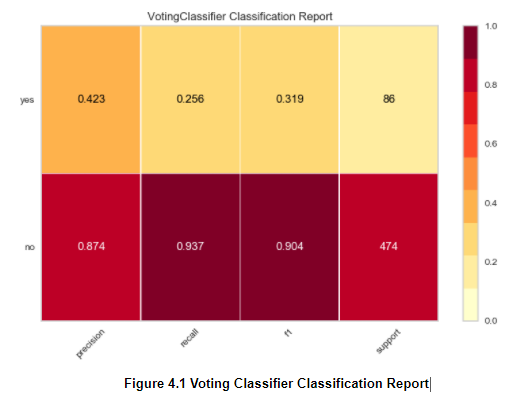

By referring to the classification report produced by our final ensemble model, we can come to a firm conclusion that results of our model are within logical and acceptable range. Due to the extensive checking and selection of our features, we are confident to say that the features used in our model training has contributed significantly to the accuracy of our model. The high accuracy in predicting the likelihood of customers responding will be able to aid the hypermarket executives in planning and selecting the correct customer base to perform their marketing campaigns. Furthermore, the high recall in our model also ensures that the model has a much lower chance in mislabeling potential customers as not responsive, hence mitigating the cost of losing potential profit for the hypermarket.

Therefore, to achieve our business goal, we need to obtain a model with both a high recall value and also a high precision score. With high precision, we can ensure that the company can minimize the number of responded no customers  to receive excess marketing campaign flyers and catalog with high recall, the company will not miss out on potential customers that might respond positively to future marketing campaigns and reward the right people to ensure customers loyalty in the long run.

Another metric that was utilized during the model evaluation is the Receiver Operating Characteristic Curve (ROC) and Area Under the Curve (AUC) score that is useful in determining whether a model is useful in binary classification problems. Optimally, achieving a ROC AUC score of 1.0 that means perfect separation between two class output is the best.


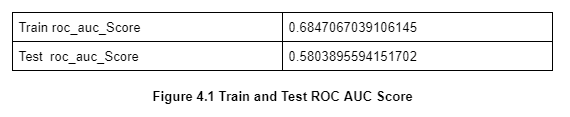

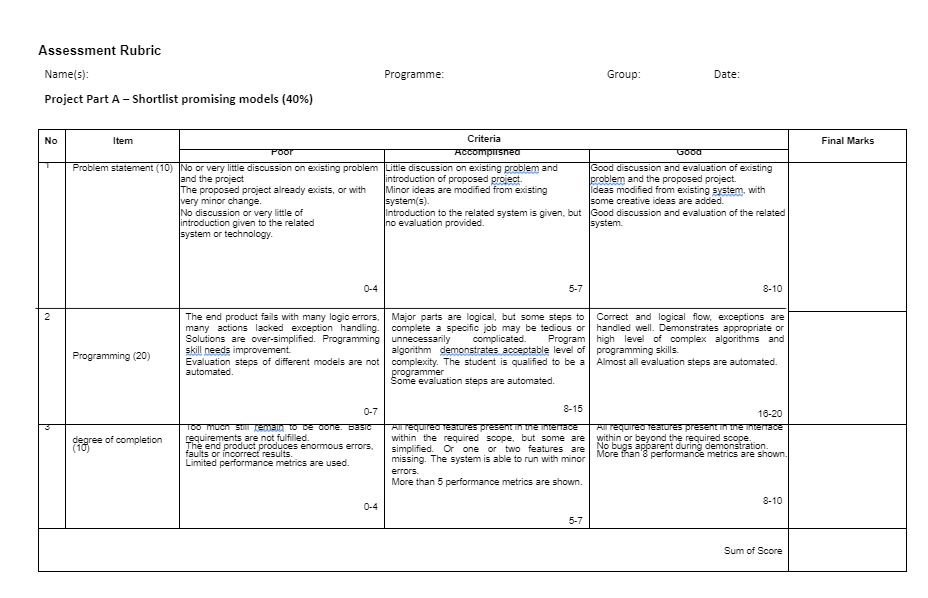

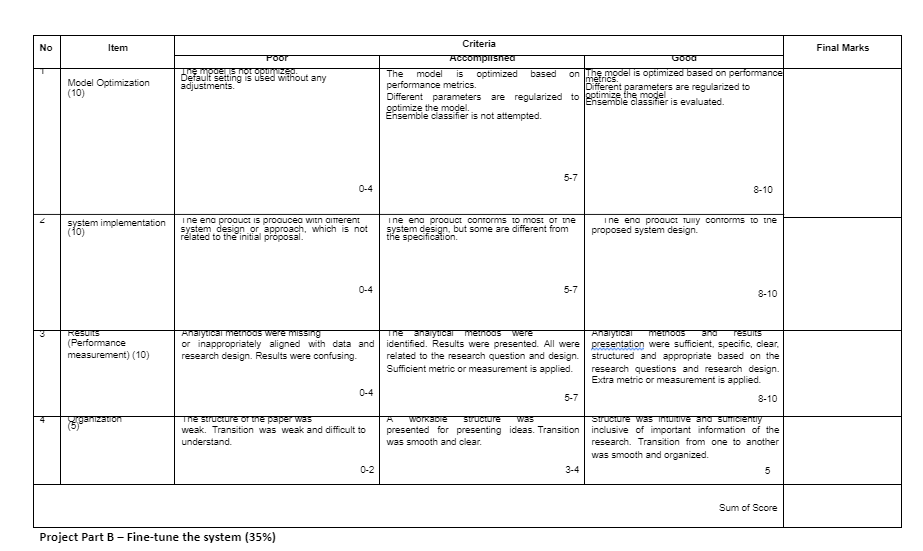

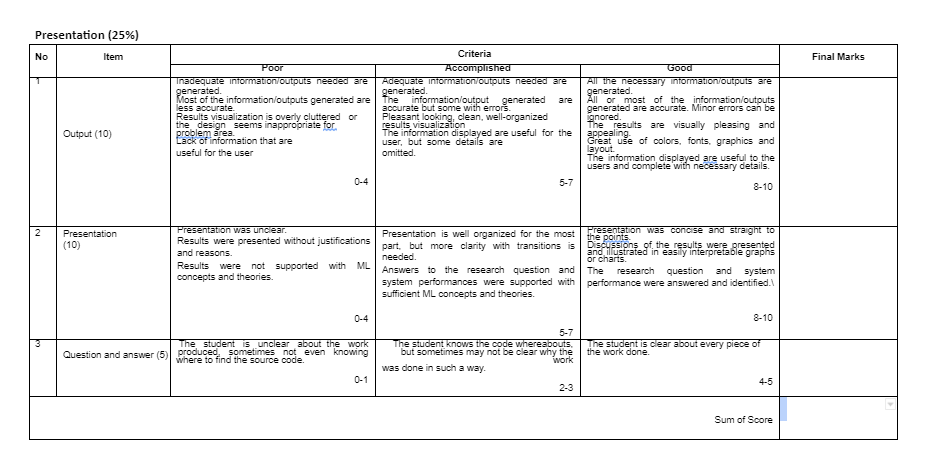